# Obtain metrics of a grid cell

This script will return metrics of grid cell like orientation and spacing.
It can be used on several grid cells to quantify average values.

## imports, helper functions

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from spikeA.Session import *
from spikeA.Spike_train_loader import Spike_train_loader
from spikeA.Cell_group import Cell_group
from spikeA.Animal_pose import Animal_pose

In [2]:
def circular_mean(angles, weights=None):
    # https://en.wikipedia.org/wiki/Circular_mean
    # https://stackoverflow.com/a/70317140
    
    if weights is None:
        weights = np.ones(len(angles))
        
    vectors = [ [w*np.cos(a), w*np.sin(a)]  for a,w in zip(angles,weights) ]
    vector = np.sum(vectors, axis=0) / np.sum(weights)    
    x,y = vector
    
    angle_mean = np.arctan2(y,x)
    vectorlen = np.linalg.norm(vector)
    angle_variance = (1. - vectorlen) * np.pi
    angle_std = np.sqrt(-2.*np.log(vectorlen))
    
    return angle_mean, vectorlen, angle_std# angle_variance

def circular_mean_period(signal, p, weights=None):
    # circular mean with arbitrary period
    #  (using period p instead of 2pi, stretch then with inverse f(X/s)*s )
    s = p/(2*np.pi)
    return ( circular_mean(np.array(signal)/s, weights=weights)[0] % (2*np.pi) ) *s

## load session

In [3]:
name="bt1296-27102022-0105"
# name="pk9254-20122022-0104"
# some light/dark protocol recording ...
# ...

In [4]:
import os

basedir = "/adata/electro"
subject, session = name.split("-",1)
path = basedir+"/"+subject+"/"+name+"/"

fname = name.split("_")[0]

print("Path:", path)
print("Mouse:", subject) # directory = mouse subject name
print("Session:", session)
print("Name:", name, ",", fname)
print("")
print("Path:", "OK" if os.path.isdir(path) else "invalid")

Path: /adata/electro/bt1296/bt1296-27102022-0105/
Mouse: bt1296
Session: 27102022-0105
Name: bt1296-27102022-0105 , bt1296-27102022-0105

Path: OK


In [5]:
ses = Kilosort_session(name=fname, path=path)
ses.load_parameters_from_files()
print(ses)

<class 'spikeA.Session.Kilosort_session'>
name = bt1296-27102022-0105
path = /adata/electro/bt1296/bt1296-27102022-0105
subject = bt1296
session_dat_time = 2022-10-27 01:05:00
fileBase = /adata/electro/bt1296/bt1296-27102022-0105/bt1296-27102022-0105
data_type = kilosort
file_names = {'par': '/adata/electro/bt1296/bt1296-27102022-0105/bt1296-27102022-0105.par', 'desen': '/adata/electro/bt1296/bt1296-27102022-0105/bt1296-27102022-0105.desen', 'desel': '/adata/electro/bt1296/bt1296-27102022-0105/bt1296-27102022-0105.desel', 'sampling_rate': '/adata/electro/bt1296/bt1296-27102022-0105/bt1296-27102022-0105.sampling_rate_dat', 'stimulation': '/adata/electro/bt1296/bt1296-27102022-0105/bt1296-27102022-0105.stimulation', 'px_per_cm': '/adata/electro/bt1296/bt1296-27102022-0105/bt1296-27102022-0105.px_per_cm', 'setup': '/adata/electro/bt1296/bt1296-27102022-0105/bt1296-27102022-0105.setup', 'environmentFamiliarity': '/adata/electro/bt1296/bt1296-27102022-0105/bt1296-27102022-0105.environmentFa

In [6]:
stl = Spike_train_loader()
stl.load_spike_train_kilosort(ses)
# print("stl.clu_ids",stl.clu_ids)
cg = Cell_group(stl)
print("cells:", len(cg.neuron_list))

cells: 99


In [7]:
ap = Animal_pose(ses)
posefilename = ses.fileBase + ap.pose_file_extension
print("look for", posefilename)
if not os.path.exists(posefilename):
    print("load from positrack")
    extension = ap.positrack_type()
    print("use extension:",extension)
    ap.pose_from_positrack_files(ses=ses, interpolation_frequency_hz = 50, extension=extension)
    ap.save_pose_to_file() # save the file for next time
else:
    print("load from saved pose file")
    ap.load_pose_from_file()

look for /adata/electro/bt1296/bt1296-27102022-0105/bt1296-27102022-0105.pose.npy
load from saved pose file


In [8]:
trial = 2

In [9]:
session_trials = ses.session_trials()
tn,su,en,(shape,diam,color,cue),ef,iv = session_trials[trial]

In [10]:
tn,su,en,(shape,diam,color,cue),ef,iv

('bt1296-27102022_03',
 '28a',
 'sqr70',
 ('square', 70.0, None, None),
 'novel',
 array([1814.688  , 3021.19195]))

In [11]:
## restrict to trial = set appropriate interval
ap.set_intervals(iv)
cg.set_spatial_properties(ap)

# detect xy_range (do this once per trial, use this for every neuron later)
xy_range = ap.find_xy_range(diameter = diam)
center = np.mean(xy_range,axis=0)

ap.invalid_outside_spatial_area(environment_shape=shape, radius=diam/2., length=diam, center=center)
ap.occupancy_map_2d()


firing_rate_maps = []
grid_scores = []
grid_hex = [] # radius and rotation

for N, n in enumerate(cg.neuron_list):
    # set interval to specific trial
    n.spatial_properties.set_intervals(iv)

    # use xy_range
    n.spatial_properties.ap.invalid_outside_spatial_area(environment_shape=shape, radius=diam/2., length=diam, center=center)        

    # plot firing rate map
    n.spatial_properties.firing_rate_map_2d(cm_per_bin=2, smoothing_sigma_cm=2, smoothing=True, xy_range=xy_range)
    firing_rate_map = n.spatial_properties.firing_rate_map
    firing_rate_maps.append(firing_rate_map)
    
    grid_score = n.spatial_properties.grid_score()
    grid_scores.append(grid_score)
    
    grid_info = n.spatial_properties.grid_info()
    rad,rot,*_ = grid_info
    grid_hex.append([rad,rot])
    
    
firing_rate_maps = np.array(firing_rate_maps)
grid_scores = np.array(grid_scores)
grid_hex = np.array(grid_hex)

In [12]:
firing_rate_maps.shape, grid_scores.shape

((99, 35, 35), (99,))

## select grid cells

In [13]:
# choose some grid cells with highest grid score
n_cells = 6
grid_cells = np.flip(np.argsort(grid_scores))[:n_cells]
grid_cells

array([96, 76, 64, 67, 71, 98])

### calculate grid cell metrics

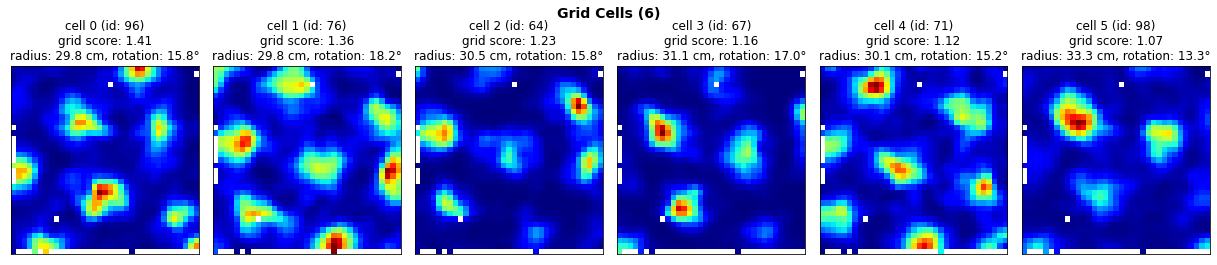

In [14]:
fig,ax = plt.subplots(ncols=len(grid_cells), nrows=1, figsize=(17,4))

for i, (gc_id, fmap, grid_score, (rad,rot)) in enumerate(zip(grid_cells, firing_rate_maps[grid_cells], grid_scores[grid_cells], grid_hex[grid_cells])):
    ax[i].imshow(fmap.T, cmap='jet')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title("cell {} (id: {})\ngrid score: {:.2f}\nradius: {:.1f} cm, rotation: {:.1f}°".format(i, gc_id, grid_score, rad, np.rad2deg(rot)))

plt.suptitle("Grid Cells ({})".format(len(grid_cells)), fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

In [15]:
# grid metrics:

In [16]:
grid_hex[grid_cells]

array([[29.83286778,  0.27502158],
       [29.83286778,  0.31733259],
       [30.48884539,  0.27502158],
       [31.05644628,  0.29617709],
       [30.09866034,  0.26444383],
       [33.314012  ,  0.23271057]])

In [17]:
radii,rotations = grid_hex[grid_cells].T
radii,rotations

(array([29.83286778, 29.83286778, 30.48884539, 31.05644628, 30.09866034,
        33.314012  ]),
 array([0.27502158, 0.31733259, 0.27502158, 0.29617709, 0.26444383,
        0.23271057]))

In [18]:
# calculate means:

In [19]:
rad_mean = np.mean(radii)
rot_mean = circular_mean_period(rotations, p=np.radians(60))
rad_mean, rot_mean

(30.7706165954535, 0.27679815292197685)

In [20]:
print("means:")
print("radius: {:.1f} cm".format(rad_mean))
print("rotation: {:.1f}°".format(np.rad2deg(rot_mean)))

means:
radius: 30.8 cm
rotation: 15.9°


In [21]:
# weight by grid score

In [22]:
scores = grid_scores[grid_cells]
scores

array([1.41106932, 1.36068686, 1.22798113, 1.16275022, 1.12408881,
       1.07220563])

In [23]:
rad_mean_weigthed = np.average(radii, weights=scores)
rot_mean_weighted = circular_mean_period(rotations, p=np.radians(60), weights=scores)
rad_mean_weigthed, rot_mean_weighted

(30.683486972276405, 0.2784225136621141)

In [24]:
print("weighted means:")
print("radius: {:.1f} cm".format(rad_mean_weigthed))
print("rotation: {:.1f}°".format(np.rad2deg(rot_mean_weighted)))

weighted means:
radius: 30.7 cm
rotation: 16.0°


## detailed for one grid cell

In [25]:
i = 0
gc_id = grid_cells[i]
n = cg.neuron_list[gc_id]
i, gc_id, n.name

(0, 96, '267')

In [26]:
# calculate grid score, this calls calculate_doughnut() which in turn calls spatial_autocorrelation_field_detection() which in turn calls spatial_autocorrelation_map_2d() and sets points_inside_dougnut
grid_score = n.spatial_properties.grid_score()
grid_score

1.411069317738117

In [27]:
points_inside_dougnut = np.array(n.spatial_properties.points_inside_dougnut)
points_inside_dougnut

array([[20, 31],
       [24, 45],
       [31, 21],
       [35, 35],
       [39, 49],
       [46, 25],
       [50, 39]])

In [28]:
# this calculates the grid cell metrics
grid_info = n.spatial_properties.grid_info()
hexagon_radius, rotation, error, hexagon_rotated = grid_info
grid_info

(29.832867780352593,
 0.27502157910213676,
 5.0011186151953675,
 array([[49.85586442, 39.55082172],
        [39.1698177 , 49.95795415],
        [24.81395327, 45.90713242],
        [21.14413558, 31.44917828],
        [31.8301823 , 21.04204585],
        [46.18604673, 25.09286758],
        [49.85586442, 39.55082172]]))

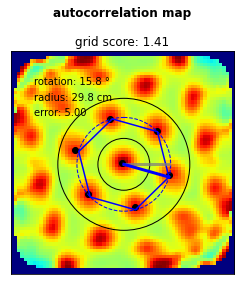

In [29]:
fig,ax = plt.subplots()



ax.imshow(n.spatial_properties.spatial_autocorrelation_map.T, cmap='jet')
ax.set_title("grid score: {:.2f}".format(grid_score))
ax.set_xticks([])
ax.set_yticks([])

# could we find fields inside doughnut
if len(points_inside_dougnut):
    midpoint = n.spatial_properties.autocorr_midpoint
    circle_outer = plt.Circle(midpoint, n.spatial_properties.r_outer_radius_use, color='black' , fill=False)
    circle_inner = plt.Circle(midpoint, n.spatial_properties.r_inner_radius_use, color='black' , fill=False)
    ax.scatter(points_inside_dougnut[:,0],points_inside_dougnut[:,1], color='black')
    ax.add_patch(circle_outer)
    ax.add_patch(circle_inner)
    
    # did we obtain a valid grid info
    if np.isfinite(hexagon_radius):
        circle_median = plt.Circle(midpoint, hexagon_radius/ap.occupancy_cm_per_bin, color='blue', ls='dashed', fill=False)
        ax.add_patch(circle_median)
        ax.plot(hexagon_rotated[:,0], hexagon_rotated[:,1] , color="blue")
        
        ax.plot([midpoint[0],hexagon_rotated[0,0]] , [midpoint[1],midpoint[1]] , color="grey", lw=3, alpha=.75)
        ax.plot([midpoint[0],hexagon_rotated[0,0]] , [midpoint[1],hexagon_rotated[0,1]] , color="blue", lw=3)
        
        ax.text(7,10, "rotation: {:3.1f} °".format(np.rad2deg(rotation)))
        ax.text(7,15, "radius: {:.1f} cm".format(hexagon_radius))
        ax.text(7,20, "error: {:.2f}".format(error))



plt.suptitle("autocorrelation map", fontweight='bold')
plt.tight_layout()
plt.show()